# Проект «Выявление токсичных комментариев»

На основе базы комментариев с отметками о токсичности обучить модель для классификации комментариев на позитивные и негативные. Добиться метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import re
import time
from datetime import datetime
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning, DeprecationWarning))
pd.options.mode.chained_assignment = None

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import gensim.models
from gensim import utils
from gensim.models import Word2Vec
from gensim.test.utils import datapath


### Загрузка данных

In [4]:
df = pd.read_csv("datasets/toxic_comments.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
#df = df.sample(n=50000,random_state=42)

In [7]:
len(df)

159571

In [8]:
df.sample(20, random_state=42)

,text,toxic
119105,"Geez, are you forgetful! We've already discus...",0
131631,Carioca RFA \n\nThanks for your support on my ...,0
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0
111256,Pseudoscience category? \n\nI'm assuming that ...,0
83590,"(and if such phrase exists, it would be provid...",0
37546,", 9 October 2007 (UTC)\n\nP.s, the delta funct...",0
98371,"]]- 10 September 1910, [[[Couvet]] )",0
67118,Negro league baseball task-force talk].,0
129625,List of My Three Sons episodes \n\nI saw you r...,0
48941,Quoting Loremaster: In order to make sure you ...,0


Судя по всему, данные содержат тексты на английском языке. Тексты требуют удаления некоторых спецсимволов.

### Подготовка

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Eugenio
[nltk_data]     Sorriso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Eugenio
[nltk_data]     Sorriso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
stopwords = set(nltk_stopwords.words('english'))

In [11]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [12]:
## шаблон поиска слов, состоящих не из одних лишь цифр
TOKEN_RE = re.compile(r'[A-Za-z\d]*[A-Za-z][A-Za-z\d]*')

def clear_text(text, min_token_size=2):
    ## преводим текст в нижний регистр
    text = text.lower()
    ## находим все слова регулярным выржением
    tokens = TOKEN_RE.findall(text)
    ## отбираем слова длиннее заданной длины
    tokens = [token for token in tokens if len(token) >= min_token_size]
    return " ".join(tokens) 


def lemmatize_text(text):
    wnl = WordNetLemmatizer()
    return ' '.join(wnl.lemmatize(w) for w in text.split(' '))


def delete_stopwords(text, stopwords):
    return ' '.join([word for word in text.split(' ') if word not in stopwords])

In [13]:
df['text'] = df['text'].apply(lambda x: clear_text(x))

In [14]:
df.sample(50, random_state=42)

,text,toxic
119105,geez are you forgetful we ve already discussed...,0
131631,carioca rfa thanks for your support on my requ...,0
125326,birthday no worries it what do enjoy ur day talk,0
111256,pseudoscience category assuming that this arti...,0
83590,and if such phrase exists it would be provided...,0
37546,october utc the delta function use in the exam...,0
98371,september couvet,0
67118,negro league baseball task force talk,0
129625,list of my three sons episodes saw you redirec...,0
48941,quoting loremaster in order to make sure you u...,0


In [15]:
df['text'] = df['text'].apply(lambda x: lemmatize_text(x))

In [16]:
df.sample(50, random_state=42)

,text,toxic
119105,geez are you forgetful we ve already discussed...,0
131631,carioca rfa thanks for your support on my requ...,0
125326,birthday no worry it what do enjoy ur day talk,0
111256,pseudoscience category assuming that this arti...,0
83590,and if such phrase exists it would be provided...,0
37546,october utc the delta function use in the exam...,0
98371,september couvet,0
67118,negro league baseball task force talk,0
129625,list of my three son episode saw you redirecte...,0
48941,quoting loremaster in order to make sure you u...,0


In [17]:
df['text'] = df['text'].apply(lambda x: delete_stopwords(x, stopwords))

In [18]:
df.sample(50, random_state=42)

,text,toxic
119105,geez forgetful already discussed marx wa anarc...,0
131631,carioca rfa thanks support request adminship f...,0
125326,birthday worry enjoy ur day talk,0
111256,pseudoscience category assuming article pseudo...,0
83590,phrase exists would provided search engine eve...,0
37546,october utc delta function use example kroneck...,0
98371,september couvet,0
67118,negro league baseball task force talk,0
129625,list three son episode saw redirected two seas...,0
48941,quoting loremaster order make sure understand,0


Рассмотрим, какой длины тексты у нас имеются

In [19]:
df['len'] = df['text'].apply(lambda x: len(x))

In [20]:
df['len'].describe()

count    159571.000000
mean        245.120191
std         383.207876
min           0.000000
25%          57.000000
50%         125.000000
75%         268.000000
max        5000.000000
Name: len, dtype: float64

<AxesSubplot:>

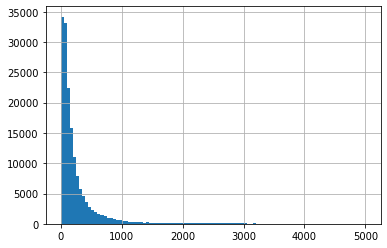

In [21]:
df['len'].hist(bins=100)

Удаляем пустые тексты с нулевой длиной

In [22]:
df = df[df['len']>0]

In [23]:
df.sample(50, random_state=42)

,text,toxic,len
112960,january utc took care road article people deal...,0,112
125815,maintaining npov simply sake npov without addr...,0,149
30240,congrats antibody ga award great work,0,37
66256,sodomite really know stick together yech never...,1,405
100943,read previous comment new user new user reques...,0,1048
94113,talk page ask question please remember sign na...,0,1307
148359,law sir syed sultan ahmed post air sir mohamma...,0,153
122196,henrietta van laer say comment clear proof wik...,0,409
6415,name point putting jeff quote name nickname je...,0,91
25642,add short synopsis act killer,0,29


In [24]:
df[df['toxic']==1]

,text,toxic,len
6,cocksucker piss around work,1,27
12,hey talk exclusive group wp taliban good destr...,1,197
16,bye look come think comming back tosser,1,39
42,gay antisemmitian archangel white tiger meow g...,1,398
43,fuck filthy mother dry,1,22
...,...,...,...
159494,previous conversation fucking shit eating libe...,1,1047
159514,mischievious pubic hair,1,23
159541,absurd edits absurd edits great white shark wa...,1,220
159546,hey listen ever delete edits ever annoyed wwe ...,1,268


### Разделение выборок на обучающую, валидационную, тестовую

In [25]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
len(train), len(test)

(127609, 31903)

In [27]:
features_train = train['text']
features_test = test['text']

In [28]:
target_train = train['toxic']
target_test = test['toxic']

Выделение части для валидации:

In [29]:
features_train_part, features_valid_part, target_train_part, target_valid_part = train_test_split(features_train, target_train, stratify=target_train, test_size=0.2, random_state=42)

### Баланс классов

In [30]:
target_train.value_counts()

0    114605
1     13004
Name: toxic, dtype: int64

Налицо явный дисбаланс классов, необходима балансировка классов

### Векторизация текстов

Преобразуем тексты в мешки слов с помощью библиотеки Tfidf

In [31]:
def get_vectorized(features_train, features_valid, features_test=None):

    corpus_train = features_train.values
    corpus_valid = features_valid.values
    if features_test is not None:
        corpus_test = features_test.values
    
    vectorizer = TfidfVectorizer(analyzer='word').fit(corpus_train)
    
    features_train_vectorized = vectorizer.transform(corpus_train)
    features_valid_vectorized = vectorizer.transform(corpus_valid)
    if features_test is not None:
        features_test_vectorized = vectorizer.transform(corpus_test)
    
    if features_test is not None:
        return features_train_vectorized, features_valid_vectorized, features_test_vectorized
    else:
        return features_train_vectorized, features_valid_vectorized 
    

## Обучение

Целевой показатель метрики f1

In [32]:
f1_goal = 0.75

### Простые модели

In [33]:
def search_model(models, hyper_params, scoring, features_train, target_train, features_test, target_test):
    
    result = []
    
    features_train_vect, features_test_vect = get_vectorized(features_train, features_test)
    
    for base_estimator in models:

        model_hyper_params = {}

        for key in hyper_params.keys():
            if key in base_estimator.get_params().keys():
                model_hyper_params[key] = hyper_params[key]    


        start_time = datetime.now()

        print(type(base_estimator).__name__, '...')

        clf = RandomizedSearchCV(base_estimator, model_hyper_params, scoring=scoring, random_state=42, n_jobs=-1)
        search = clf.fit(features_train_vect, np.ravel(target_train))

        model_learn_time = datetime.now() - start_time

        model_test_score = f1_score(target_test, clf.predict(features_test_vect)) 

        print("valid: {:.2f}".format(clf.best_score_), "test: {:.2f}".format(model_test_score))

        print()

        result.append({
            'model': type(base_estimator).__name__, 
            'metric_valid': clf.best_score_, 
            'metric_test': model_test_score, 
            'learn_time': model_learn_time,
            'hyper_params': search.best_params_
        }) 
        
    return result


In [34]:
models = [DummyClassifier(), LogisticRegression(), DecisionTreeClassifier()]

In [35]:
hyper_params = {
    'class_weight': ['balanced'],
    'max_depth': [x for x in range(16, 64, 2)], 
    'leaf_size': [x for x in range(2, 64, 2)], 
    'min_samples_leaf': [x for x in range(1, 16, 2)],
    'min_samples_split': [x for x in range(16, 64, 2)],
}

In [36]:
log_search = []

In [37]:
%%time
log_search = []
search_model_result = search_model(models, hyper_params, 'f1', features_train, target_train, features_test, target_test)
log_search += search_model_result

DummyClassifier ...
valid: 0.00 test: 0.00

LogisticRegression ...
valid: 0.75 test: 0.75

DecisionTreeClassifier ...
valid: 0.61 test: 0.61

Wall time: 10min 18s


In [38]:
log_search_df = pd.DataFrame(data=log_search, 
                         columns=['model', 'metric_valid', 'metric_test', 'learn_time', 'hyper_params'])

In [39]:
log_search_df

,model,metric_valid,metric_test,learn_time,hyper_params
0,DummyClassifier,0.000000,0.000000,0 days 00:00:02.140404,{}
1,LogisticRegression,0.750974,0.745644,0 days 00:00:19.896112,{'class_weight': 'balanced'}
2,DecisionTreeClassifier,0.611103,0.613513,0 days 00:09:47.408053,"{'min_samples_split': 36, 'min_samples_leaf': ..."


Простые модели со сбалансированными классами не дают нужных результатов, кроме LogisticRegression, её  метрика f1 наилучшая.

### Upsampling: LogisticRegression

In [40]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [41]:
%%time

best_upsampling_score = 0

for repeat in tqdm(range(2, 7)):
    features_train_upsampled, target_train_upsampled = upsample(features_train_part, target_train_part, repeat)
    features_train_upsampled_vect, features_valid_vect, features_test_vect = get_vectorized(features_train_upsampled, features_valid_part, features_test)
    model = LogisticRegression(random_state=42, n_jobs=-1)
    model.fit(features_train_upsampled_vect, target_train_upsampled)
    model_valid_score = f1_score(target_valid_part, model.predict(features_valid_vect)) 
    model_test_score = f1_score(target_test, model.predict(features_test_vect)) 
    if model_valid_score > best_upsampling_score:
        best_upsampling_score = model_valid_score
    print('repeat =', repeat, 
          "valid = {:.2f}".format(model_valid_score),
          "test = {:.2f}".format(model_test_score))
    
print()    
print('Лучший показатель f1: {:.2f}'.format(best_upsampling_score))

  0%|          | 0/5 [00:00<?, ?it/s]

repeat = 2 valid = 0.77 test = 0.77
repeat = 3 valid = 0.78 test = 0.78
repeat = 4 valid = 0.78 test = 0.78
repeat = 5 valid = 0.78 test = 0.77
repeat = 6 valid = 0.77 test = 0.76

Лучший показатель f1: 0.78
Wall time: 1min 10s


### Downsampling: LogisticRegression

In [42]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled


In [43]:
%%time

best_downsampling_score = 0

for fraction in tqdm(np.arange(0.6, 0, -0.1)):
    features_train_downsampled, target_train_downsampled = downsample(features_train_part, target_train_part, fraction)
    features_train_downsampled_vect, features_valid_vect, features_test_vect = get_vectorized(features_train_downsampled, features_valid_part, features_test)
    model = LogisticRegression(random_state=42, n_jobs=-1)
    model.fit(features_train_downsampled_vect, target_train_downsampled)
    model_valid_score = f1_score(target_valid_part, model.predict(features_valid_vect)) 
    model_test_score = f1_score(target_test, model.predict(features_test_vect)) 
    if model_valid_score > best_downsampling_score:
        best_downsampling_score = model_valid_score
    print('fraction = {:.1f}'.format(fraction), 
          "valid = {:.2f}".format(model_valid_score), 
          "test = {:.2f}".format(model_test_score))
print()     
print('Лучший показатель f1: {:.2f}'.format(best_downsampling_score))

  0%|          | 0/6 [00:00<?, ?it/s]

fraction = 0.6 valid = 0.75 test = 0.75
fraction = 0.5 valid = 0.75 test = 0.76
fraction = 0.4 valid = 0.76 test = 0.76
fraction = 0.3 valid = 0.76 test = 0.76
fraction = 0.2 valid = 0.74 test = 0.74
fraction = 0.1 valid = 0.64 test = 0.64

Лучший показатель f1: 0.76
Wall time: 36.2 s


Downsampling также может повысить качество, но меньше, чем upsampling

### WordToVec

Попробуем сделать векторизацию с помощью WordToVec. Соберём текст из обучающей выборки. Создадим корпус и словарь векторов из него. Каждому тексту в выборке сопоставим сумму векторов его слов.

#### Обработка корпуса

Соберём корпус из обучающей выборки

In [44]:
entire_text = features_train.str.cat(sep=" ")

In [45]:
len(entire_text)

31570772

Собираем все предложения в список

In [46]:
all_sentences = nltk.sent_tokenize(entire_text)

In [47]:
entire_text = None

In [48]:
len(all_sentences)

1

Собираем все слова в список списков

In [49]:
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

In [50]:
len(all_words)

1

In [51]:
all_sentences = None

Формируем веса на основе нашего обучающего текста, учитывая только слова, встречающиеся не менее 4 раз

In [52]:
word2vec = Word2Vec(all_words, min_count=4)

#### Функция сопоставления вектора слову

In [53]:
def get_vectors(text):
    vecs = [np.zeros(100)]
    for w in utils.simple_preprocess(text):

        try:
            v = word2vec.wv[w]
        except:
            v = np.zeros(100)

        vecs.append(v)

    return np.sum(np.array(vecs),axis=0)

In [54]:
train['w2v'] = train['text'].apply(lambda x: get_vectors(x))

In [55]:
test['w2v'] = test['text'].apply(lambda x: get_vectors(x))

In [56]:
features_train_w2v = pd.DataFrame(train["w2v"].to_list())

In [57]:
len(features_train_w2v), len(target_train)

(127609, 127609)

In [58]:
features_test_w2v = pd.DataFrame(test["w2v"].to_list())

In [59]:
len(features_test_w2v), len(target_test)

(31903, 31903)

In [60]:
features_train_w2v_part, features_valid_w2v_part, target_train_part, target_valid_part = train_test_split(
    features_train_w2v, target_train, stratify=target_train, test_size=0.2, random_state=42)

In [61]:
len(features_train_w2v_part), len(target_train_part), len(features_valid_w2v_part), len(target_valid_part)

(102087, 102087, 25522, 25522)

In [62]:
model = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(features_train_w2v_part, target_train_part)
model_valid_score = f1_score(target_valid_part, model.predict(features_valid_w2v_part)) 
model_test_score = f1_score(target_test, model.predict(features_test_w2v)) 
print("valid = {:.2f}".format(model_valid_score), 
      "test = {:.2f}".format(model_test_score))

valid = 0.31 test = 0.31


Определим веса классов

In [63]:
cw = [1,(target_train_part==0).sum() / (target_train_part==1).sum()]

In [64]:
cw

[1, 8.813226953763337]

In [65]:
model = CatBoostClassifier(verbose=100,
                           learning_rate=0.5,
                           early_stopping_rounds=200,
                           eval_metric='F1',
                           iterations=200,
                           class_weights=cw)

In [66]:
model.fit(features_train_w2v_part, target_train_part,
          eval_set=(features_valid_w2v_part, target_valid_part))

0:	learn: 0.6183309	test: 0.6162671	best: 0.6162671 (0)	total: 226ms	remaining: 44.9s
100:	learn: 0.8078597	test: 0.6812548	best: 0.6887094 (84)	total: 5.04s	remaining: 4.94s
199:	learn: 0.8858440	test: 0.6495875	best: 0.6887094 (84)	total: 10.2s	remaining: 0us

bestTest = 0.6887093882
bestIteration = 84

Shrink model to first 85 iterations.


In [67]:
model_test_score = f1_score(target_test, model.predict(features_test_w2v)) 
print("test = {:.2f}".format(model_test_score))

test = 0.34


## Выводы

Мы обработали тексты, создав мешок слов и применив к ним оценку важности TF-IDF с помощью библиотеки TfidfVectorizer, исключив стоп-слова из nltk_stopwords.

Среди рассмотренных нами простых моделей, самый быстрый и высокий результат показала модель LogisticRegression. 

f1 (valid) = 0.750974	
f1 (test) = 0.745644

Балансировка классов методом upsampling позволяет поднять метрику до приемлемых значений. Downsampling 

repeat = 3 
f1 (valid) = 0.78 
f1 (test) = 0.78


Мы также попробовали векторизовать данные с помощью word2vec. 
Модельный ансамбль CatBoostClassifier обучился до метрики F1 0.68.  Этот результат лучше, чем у логистической регрессии (0.31). Но, к сожалению, на тестовой выборке результат низкий. Возможно, модель переобучилась. Либо надо совершенствовать общий корпус, или, возможно, использовать корпус, обученный на разговорных тестах.

Таким образом, лучший результат для нас, это векторизация текста с помощью TF-IDF, обучение logisticRegression с 3-х кратным upsampling-ом.